# ORIE 4580/5580/5581 Assignment 3

#### Students: Maoxuan Xu(mx266) and Yichen Zhu ()

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)

(**Please replace this with your own link!**)

### Instructions


* Due Thursday September 25, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 7 (you can skim through this), and chapters 8 and 9 of [Introduction to Probability](https://chance.dartmouth.edu/teaching_aids/books_articles/probability_book/book.html) by Grinstead and Snell.

Chapter 3 and chapter 4 (up to section 4.5) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [25]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

<hr><hr>

## Question 1: Combining LCGs (20 points)

In order to avoid biases, simulations should not use anywhere near the full period of an LCG (otherwise, the random sequence repeats\ldots). For example, a typical traffic simulator may have $10,000$ vehicles, each experiencing thousands of random disturbances, thus needing around $10^7$ random samples per replication -- for this, an LCG using $m=2^{31}-1\approx 2\times 10^9$ is insufficient, as after $100$ replications the sequences get correlated.

One method to combine multiple LCGs to obtain a generator with a longer period is to add a smaller period LCG to it. For example, suppose we have two generators $X_{n+1}  =  (a_1 X_n) \mbox{ mod } m_1$ and $Y_{n+1}  =  (a_2 Y_n) \mbox{ mod } m_2$, with $m_1>m_2$. We can derive a combined generator by setting $Z_n  =  (X_n + Y_n) \mbox{ mod } m_1$. If properly designed, the resulting period can be on the order of $m_1m_2$. We will now study a small example to see how this works.


<hr>

**(a)** Consider two LCGs, $x_{n+1} = (5 x_n) \mod 16$ and $y_{n+1} = (2 y_n) \mod 7$. Starting both with seed $x_0 = y_0 = 1$, plot the sequences $x_n, y_n$ using the clock visualization introduced in class (separate plot for each sequence; you can use and modify the code in Demo-PRNGs.ipynb on Canvas).

<hr>

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def _state_xy(i: int, m: int):
    theta = 2.0 * np.pi * (i % m) / m
    return np.cos(theta), np.sin(theta)

def plot_clock_face(m: int, annotate: bool = False):
    ax = plt.gca()
    ax.add_patch(plt.Circle((0, 0), 1.0, fill=False, linewidth=1.0))
    xs, ys = zip(*(_state_xy(i, m) for i in range(m)))
    ax.scatter(xs, ys, s=35, zorder=3)
    if annotate:
        for i in range(m):
            x, y = _state_xy(i, m)
            ax.text(x*1.08, y*1.08, str(i), ha="center", va="center", fontsize=9)
    ax.set_aspect("equal")
    ax.axis("off")

def plot_clock_path(states, m: int, show_seed=True, color="C0"):
    if show_seed and len(states) > 0:
        x0, y0 = _state_xy(states[0], m)
        plt.scatter([x0], [y0], s=80, marker="s", zorder=4, color=color)
    for i in range(len(states) - 1):
        xs, ys = _state_xy(states[i], m)
        xe, ye = _state_xy(states[i+1], m)
        plt.annotate("", xy=(xe, ye), xytext=(xs, ys),
                     arrowprops=dict(arrowstyle="-|>", lw=1.2, color=color))

In [31]:
def lcg_states(n: int, m: int, a: int, c: int, seed: int):
    x = seed % m
    seq = [x]
    for _ in range(n):
        x = (a * x + c) % m
        seq.append(x)
    return np.array(seq, dtype=int)

def lcg_uniform(n: int, m: int = 2**31 - 1, a: int = 1103515245, c: int = 12345, seed: int = 1):
    xs = lcg_states(n, m, a, c, seed)[1:]
    return xs.astype(float) / float(m)


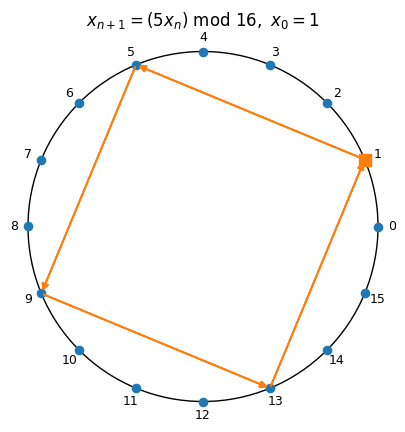

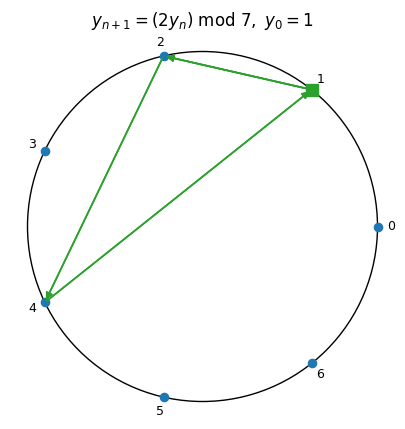

In [32]:
m1, a1, c1, s1 = 16, 5, 0, 1
xn = lcg_states(m1, m1, a1, c1, s1)
plt.figure(figsize=(5,5))
plot_clock_face(m1, annotate=True)
plot_clock_path(xn, m1, color="C1")
plt.title(r"$x_{n+1}=(5x_n)\ \mathrm{mod}\ 16,\ x_0=1$")
plt.show()

# y_{n+1} = (2 y_n) mod 7, y0=1
m2, a2, c2, s2 = 7, 2, 0, 1
yn = lcg_states(m2, m2, a2, c2, s2)
plt.figure(figsize=(5,5))
plot_clock_face(m2, annotate=True)
plot_clock_path(yn, m2, color="C2")
plt.title(r"$y_{n+1}=(2y_n)\ \mathrm{mod}\ 7,\ y_0=1$")
plt.show()

<hr>

**(b)** Next, define a combined LCG as $z_{n} = (x_n+y_n) \mod 16$. Starting both the base LCGs with seed $x_0 = y_0 = 1$, plot the sequence $z_n$ using the clock visualization given in class.

<hr>

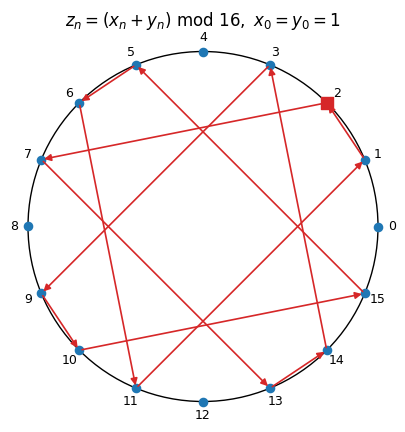

Period of x: 4
Period of y: 3
Period of z: 12


In [33]:
from math import lcm

# base LCGs
m1, a1, c1, s1 = 16, 5, 0, 1   # x_{n+1} = 5 x_n (mod 16), x0=1
m2, a2, c2, s2 = 7,  2, 0, 1   # y_{n+1} = 2 y_n (mod 7),  y0=1

# periods of the two cycles are 4 and 3 respectively, so use their lcm
N = lcm(4, 3)                   # = 12

xn = lcg_states(N, m1, a1, c1, s1)  # length N+1 (includes seed)
yn = lcg_states(N, m2, a2, c2, s2)  # length N+1

zn = (xn + yn) % m1                 # combine element-wise, still length N+1

plt.figure(figsize=(5,5))
plot_clock_face(m1, annotate=True)
plot_clock_path(zn, m1, color="C3")
plt.title(r"$z_n=(x_n+y_n)\ \mathrm{mod}\ 16,\ x_0=y_0=1$")
plt.show()

# (optional) quick period check for z
def first_return_period(states):
    start = states[0]
    for k in range(1, len(states)):
        if states[k] == start:
            return k
    return None

print("Period of x:", first_return_period(xn))
print("Period of y:", first_return_period(yn))
print("Period of z:", first_return_period(zn))

___
**(c)** What are the periods of the pseudo-random sequences $x_n, y_n$ and $z_n$?
___

### Ans.
$$
\begin{aligned}
\operatorname{Period}(x_n)&=4,\\
\operatorname{Period}(y_n)&=3,\\
\operatorname{Period}(z_n)&=12.
\end{aligned}
$$

___
___
## Question 2: inverting cdfs (25 pts)

In class, we defined $F^{-1}(y)$ for a continuous increasing cdf $F(x)$ as the unique $x$ such that $F(x) = y$ (for $y\in[0,1]$). More generally, for any cdf $F$ we can use the inversion method based on its generalized inverse or *pseudoinverse*:
	$$F^{-1}(y) = \inf\{x|F(x)\geq y\}$$
	(where $\inf$ denotes the \href{https://en.wikipedia.org/wiki/Infimum_and_supremum}{infimum}; if you have not seen this before, treat it as minimum).


___
**(a)** Find the pseudoinverse $F^{-1}(y)$ for the following mixed (discrete/continuous) cdf
	$$F(x)=
	\begin{cases}
	0 & \mbox{for $x < 0$}\\
	x & \mbox{for $0 \leq x < \frac{1}{2}$}, \\
	\frac{1}{2} & \mbox{for $\frac{1}{2}\leq x < 1$}, \\
	1 & \mbox{for $x\geq 1$}
	 \end{cases}$$
___

### Ans.
## Question 2 (a): Inverting CDFs


- **Case 1: $y = 0$**  
  We need the smallest $x$ with $F(x) \geq 0$. Since $F(x) \geq 0$ for all $x$, the infimum is $-\infty$.  
  $$
  F^{-1}(0) = -\infty \quad \text{(or 0).}
  $$

- **Case 2: $0 < y < \tfrac{1}{2}$**  
  On the interval $0 \leq x < \tfrac{1}{2}$, we have $F(x)=x$, which is strictly increasing.  
  Thus solving $F(x) \geq y$ gives $x \geq y$, and the smallest such $x$ is exactly $y$.  
  $$
  F^{-1}(y) = y, \quad 0 < y < \tfrac{1}{2}.
  $$

- **Case 3: $y = \tfrac{1}{2}$**  
  At $x=\tfrac{1}{2}$, $F(x)$ jumps to $\tfrac{1}{2}$.  
  Thus the smallest $x$ with $F(x)\geq \tfrac{1}{2}$ is $x=\tfrac{1}{2}$.  
  $$
  F^{-1}\!\left(\tfrac{1}{2}\right) = \tfrac{1}{2}.
  $$

- **Case 4: $\tfrac{1}{2} < y \leq 1$**  
  For $\tfrac{1}{2} \leq x < 1$, $F(x)=\tfrac{1}{2}$, which is not large enough.  
  At $x=1$, $F(x)$ jumps to $1$, which covers all $y \in (\tfrac{1}{2},1]$.  
  Therefore the infimum is $x=1$.  
  $$
  F^{-1}(y) = 1, \quad \tfrac{1}{2} < y \leq 1.
  $$

---

### Final result

Putting it all together:

$$
F^{-1}(y) =
\begin{cases}
-\infty \ \text{(or $0$)}, & y=0, \\[6pt]
y, & 0 < y < \tfrac{1}{2}, \\[6pt]
\tfrac{1}{2}, & y = \tfrac{1}{2}, \\[6pt]
1, & \tfrac{1}{2} < y \leq 1.
\end{cases}
$$

___
**(b)** Use the above definition to get an inversion algorithm for the $Geometric(p)$ distribution (with pmf $p(k) = p(1-p)^{k-1}\,\forall\,k\in\{1,2,3,\ldots\}$). Implement this, and generate and plot the histogram of 1000 samples from a $Geometric(0.42)$ distribution.
(For this, it may be useful for you to first understand how the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library works, and in particular, how it provides methods to compute various statistics for many different random variables, including the [geometric r.v.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html#scipy.stats.geom))
___

### Inversion method for the Geometric$(p)$ (support $\{1,2,\dots\}$)

For $X\sim\mathrm{Geometric}(p)$ with pmf $P(X=k)=p(1-p)^{k-1}$, the CDF is
$$
F(k)=P(X\le k)=\sum_{j=1}^{k}p(1-p)^{j-1}=1-(1-p)^k,\qquad k=1,2,\dots
$$

Given $U\sim\mathrm{Unif}(0,1)$, the pseudoinverse is
$$
F^{-1}(U)=\inf\{k\in\mathbb{N}: F(k)\ge U\}.
$$
Solve $1-(1-p)^k\ge U \iff (1-p)^k\le 1-U$.  
Taking logs (note $\log(1-p)<0$),
$$
k \;\ge\; \frac{\log(1-U)}{\log(1-p)}.
$$
Hence an integer solution is
$$
X=\left\lceil \frac{\log(1-U)}{\log(1-p)} \right\rceil
$$



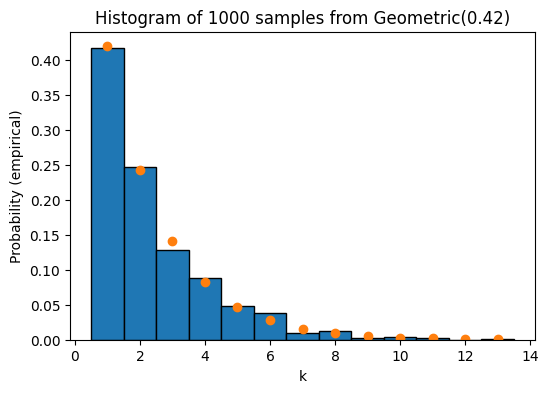

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def geometric_icdf(u, p):
    """
    Inverse-CDF for Geometric(p) with support {1,2,...}.
    u: array-like in (0,1)
    p: success prob in (0,1)
    returns: integer array of same shape as u
    """
    u = np.asarray(u)
    # log1p(x) = log(1+x) avoids precision loss when x ~ 0
    k = np.floor(np.log1p(-u) / np.log1p(-p)).astype(int) + 1
    return k

def rgeom(size, p, rng=None):
    """
    Sample 'size' draws from Geometric(p) using inversion.
    """
    if rng is None:
        rng = np.random.default_rng()
    u = rng.random(size=size)           # in [0,1)
    return geometric_icdf(u, p)

# ---- generate 1000 samples from Geometric(0.42) and plot ----
p = 0.42
n = 1000
samples = rgeom(n, p)

# histogram bins centered on integers 1,2,... up to max observed
kmax = samples.max()
bins = np.arange(0.5, kmax + 1.5, 1)

plt.figure(figsize=(6,4))
plt.hist(samples, bins=bins, density=True, edgecolor='k')
plt.xlabel('k')
plt.ylabel('Probability (empirical)')
plt.title('Histogram of 1000 samples from Geometric(0.42)')

# (optional) overlay the theoretical pmf without scipy
k_vals = np.arange(1, kmax + 1)
pmf = p * (1 - p) ** (k_vals - 1)
plt.plot(k_vals, pmf, marker='o', linestyle='none')  # overlay points
plt.show()


___
**(c)** The p.d.f. of the random variable $X$ is given by
	$$
	f(x) =
	\begin{cases}
		e^{x-2} & \text{for }0 \leq x \leq 2, \\
		e^{-x} & \text{for }x > 2, \\
		0 & \text{otherwise,}
	\end{cases}
	$$
	Describe and implement an inversion algorithm to generate samples of $X$. Generate 1,000 samples and plot a histogram. Compare the histogram and the p.d.f.


___

### Ans.


**Step 1: CDF.**

For $x<0$, $F(x)=0$.

$$
F(x) = \int_0^x e^{t-2}\,dt = \big[e^{t-2}\big]_0^x
= e^{x-2} - e^{-2}.
$$

For $x \ge 2$,

$$
F(x) = F(2) + \int_2^x e^{-t}\,dt
= \big(1 - e^{-2}\big) + \big[-e^{-t}\big]_2^x
= 1 - e^{-x}.
$$

Thus
$$
F(x)=
\begin{cases}
0, & x<0,\\[4pt]
e^{x-2}-e^{-2}, & 0\le x\le 2,\\[4pt]
1-e^{-x}, & x\ge 2.
\end{cases}
$$

Note $F$ is continuous at $x=2$ with $F(2)=1-e^{-2}$.

**Step 2: Inverse CDF**

Let $U\sim \mathrm{Unif}(0,1)$ and $u_0 = 1 - e^{-2}$. The inversion sampler is

$$
X =
\begin{cases}
2 + \ln\!\big(U + e^{-2}\big), & 0 \le U \le 1 - e^{-2} \\[6pt]
-\ln\!\big(1 - U\big), & 1 - e^{-2} < U 
\end{cases}
$$

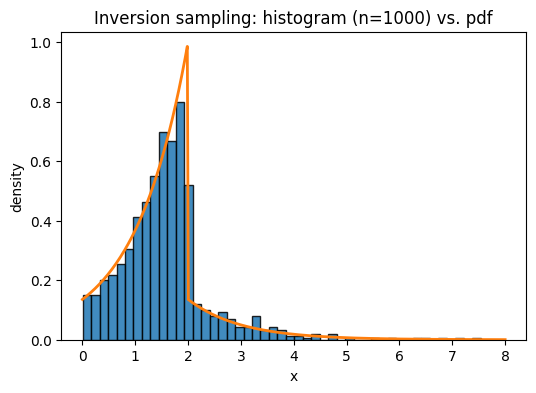

In [35]:
import numpy as np
import matplotlib.pyplot as plt

u0 = 1 - np.exp(-2.0)  # breakpoint in U-space

def sample_X(size, rng=None):
    """Inverse-CDF sampler for the given piecewise pdf."""
    rng = np.random.default_rng() if rng is None else rng
    U = rng.random(size=size)  # in [0,1)
    X = np.where(
        U <= u0,
        2.0 + np.log(U + np.exp(-2.0)),   # branch for 0 <= U <= 1-e^{-2}
        -np.log(1.0 - U)                  # branch for 1-e^{-2} < U < 1
    )
    return X

def pdf_x(x):
    """The target pdf f(x) (vectorized)."""
    x = np.asarray(x)
    return np.where(
        (x >= 0) & (x <= 2),
        np.exp(x - 2.0),
        np.where(x > 2, np.exp(-x), 0.0)
    )

# ---- draw samples and plot ----
n = 1000
x_samp = sample_X(n)

# histogram
plt.figure(figsize=(6,4))
bins = 'auto'
plt.hist(x_samp, bins=bins, density=True, edgecolor='k', alpha=0.85)

# overlay pdf on a grid spanning the sample range
x_grid = np.linspace(0, max(8, x_samp.max()), 400)
plt.plot(x_grid, pdf_x(x_grid), linewidth=2)

plt.xlabel('x'); plt.ylabel('density')
plt.title('Inversion sampling: histogram (n=1000) vs. pdf')
plt.show()


<hr><hr>

## Question 3: Acceptance-Rejection (25 pts)

Let the random variable $X$ have density
$$f(x) = \begin{cases} (5 x^4 + 4x^3 + 3x^2+1)/4  & \text{ for } 0 \leq x \leq 1, \\
0 & \text{ otherwise. } \end{cases}$$

<hr>

**(a)** Give an acceptance-rejection algorithm to generate samples of
	$X$.

<hr>

### Ans.

Algorithm

- Repeat:

  - Draw Y ~ Uniform(0,1) and U ~ Uniform(0,1) independently.

  - Compute $f(Y) = (5Y^4 + 4Y^3 + 3Y^2 + 1)/4.$

  - If U ≤ f(Y)/M (i.e., U ≤ (5Y⁴+4Y³+3Y²+1)/13),
    - accept and set X=Y; 
    - else reject and repeat.

Acceptance rate: 1/M = 4/13 ≈ 0.3077.


In [2]:
import numpy as np

def f(x):
    return (5*x**4 + 4*x**3 + 3*x**2 + 1) / 4.0

def sample_X_AR(n, seed=0):
    rng = np.random.default_rng(seed)
    M = 13.0/4.0
    out, i, trials = np.empty(n), 0, 0
    while i < n:
        y = rng.random()
        u = rng.random()
        if u <= f(y) / M:
            out[i] = y
            i += 1
        trials += 1
    return out, n/trials  # samples, empirical acceptance rate

# demo
xs, acc = sample_X_AR(10000, seed=114514)
print("acceptance ≈", acc, " mean ≈", xs.mean())


acceptance ≈ 0.3099045493987852  mean ≈ 0.7205436683706341


<hr>

**(b)** On average, how many samples from the uniform distribution over $[0, 1]$ would your acceptance-rejection algorithm need in order to generate one sample of $X$?

<hr>

### Ans.

The acceptance probability of the rejection algorithm is

$p_{\text{acc}} = \frac{1}{M} = \frac{4}{13}$.

Therefore, the expected number of proposals needed to obtain one accepted
sample is

$\mathbb{E}[\text{\#proposals}] = \frac{1}{p_{\text{acc}}} = \frac{13}{4} \approx 3.25$.

So on average, about **3.25 uniform samples** are required to generate one sample of $X$.


<hr>

**(c)** Use your algorithm in (a) to generate 2,500 samples of $X$. Note that this will require more than 2500 uniform random variables.

Plot a histogram of your sample   and compare it against the true pdf.

<hr>

We generate $n=2500$ samples from $X$ using the acceptance–rejection sampler of part (a).  
Recall the target density on $[0,1]$ is
$f(x)=\frac{5x^4+4x^3+3x^2+1}{4}$ and we use a $\mathrm{Unif}(0,1)$ proposal
with envelope constant $M=\frac{13}{4}$, so the acceptance probability is
$p_{\text{acc}}=\frac{1}{M}=\frac{4}{13}$.

code:
1) draws until $2500$ acceptances,  
2) reports the empirical acceptance rate and the total number of uniforms consumed  
   (each proposal uses two uniforms),  
3) plots a normalized histogram of the sampled $X$ and overlays the true pdf $f(x)$.

Accepted samples = 2500
Empirical acceptance rate ≈ 0.3169 (theory: 4/13 ≈ 0.3077)
Uniform(0,1) draws used = 15778 (> 2500)


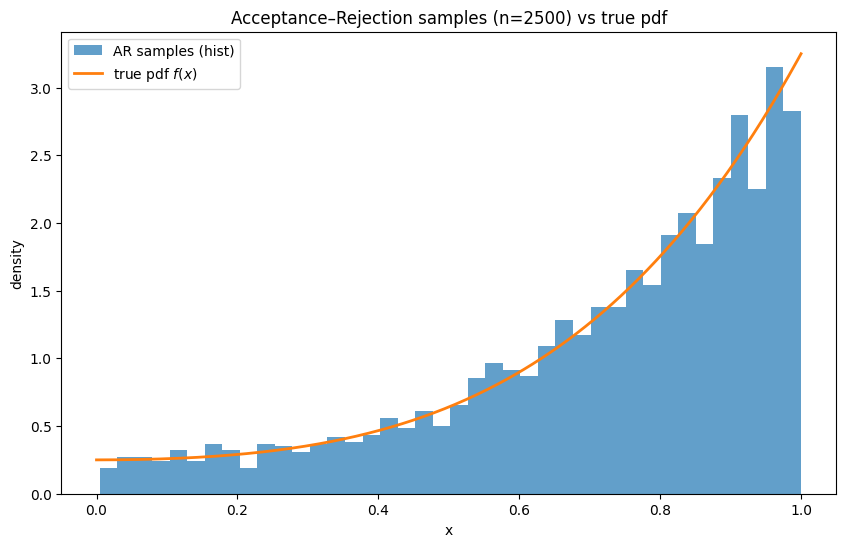

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# target density
def f(x):
    return (5*x**4 + 4*x**3 + 3*x**2 + 1) / 4.0

# acceptance–rejection sampler from part (a)
def sample_X_AR(n, seed=0):
    rng = np.random.default_rng(seed)
    M = 13.0/4.0
    out, i, trials = np.empty(n), 0, 0
    while i < n:
        y = rng.random()          # proposal ~ Unif(0,1)
        u = rng.random()          # acceptance uniform
        if u <= f(y) / M:
            out[i] = y
            i += 1
        trials += 1
    acc_rate = n / trials
    uniforms_used = 2 * trials    # two uniforms per proposal
    return out, acc_rate, uniforms_used

# generate 2500 samples
n = 2500
xs, acc, uniforms = sample_X_AR(n, seed=2025)
print(f"Accepted samples = {n}")
print(f"Empirical acceptance rate ≈ {acc:.4f} (theory: 4/13 ≈ {4/13:.4f})")
print(f"Uniform(0,1) draws used = {uniforms} (> {n})")

# plot
plt.figure(figsize=(10,6))
plt.hist(xs, bins=40, density=True, alpha=0.7, label="AR samples (hist)")
grid = np.linspace(0, 1, 400)
plt.plot(grid, f(grid), linewidth=2, label="true pdf $f(x)$")
plt.xlabel("x")
plt.ylabel("density")
plt.title("Acceptance–Rejection samples (n=2500) vs true pdf")
plt.legend()
plt.show()


<hr><hr>

## Question 4: Generalized Acceptance-Rejection (30 pts)

We want to generate a $\mathcal{N}(0,1)$ rv $X$, with pdf
$f(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}} $,
using generalized acceptance-rejection.

<hr>

**(a)** First, suppose we choose the proposal distribution to be a \emph{Laplace} (i.e., two-sided Exponential) distribution, which has pdf $g(x) = e^{-|x|}/2$. Describe (and implement) an inversion algorithm to get samples from this distribution.

<hr>

- We need samples from the Laplace (two–sided exponential) pdf: $g(x) = \tfrac{1}{2} e^{-|x|}$.

- **CDF and inverse.**

For $x \le 0$,
$F(x) = \int_{-\infty}^{x} \tfrac{1}{2} e^{t}\,dt = \tfrac{1}{2} e^{x}$.

For $x \ge 0$,
$F(x) = 1 - \int_{x}^{\infty} \tfrac{1}{2} e^{-t}\,dt = 1 - \tfrac{1}{2} e^{-x}$.

Given $U\sim\mathrm{U}(0,1)$, the inverse CDF is
$
F^{-1}(U) =
\begin{cases}
\ln(2U), & 0 < U \le \tfrac{1}{2},\\[4pt]
-\ln\!\big(2(1-U)\big), & \tfrac{1}{2} < U < 1.
\end{cases}
$

**Algorithm (inversion).**
1) Draw $U\sim\mathrm{U}(0,1)$.  
2) If $U\le \tfrac{1}{2}$, set $Y=\ln(2U)$; else set $Y=-\ln(2(1-U))$.  
Then $Y\sim \text{Laplace}(0,1)$ with pdf $g(x)$.

In [7]:
import numpy as np

def rlaplace_inv(n, seed=None):
    rng = np.random.default_rng(seed)
    U = rng.random(n)
    X = np.where(U <= 0.5, np.log(2*U), -np.log(2*(1-U)))
    return X

# check
xs = rlaplace_inv(100000, seed=42)
print(xs.mean(), xs.var())  # Laplace(0,1) has mean 0 and variance 2

0.0010576044682222454 2.009070884655501


<hr>

**(b)** Determine the smallest $k$ such that $kg(x)\geq f(x)\,\forall\,x\in\mathbb{R}$. Using this, propose (and implement) an acceptance-rejection algorithm for sampling $X\sim\mathcal{N}(0,1)$, and compute the expected number of samples needed for generating each sample.

<hr>

### Ans.

**Target:** $f(x)=\dfrac{e^{-x^2/2}}{\sqrt{2\pi}}$.

**Proposal:** Laplace $g(x)=\dfrac{1}{2}e^{-|x|}$ (from part (a)).

We need the smallest $k$ with $k\,g(x)\ge f(x)$ for all $x\in\mathbb{R}$, i.e.
$
k=\sup_{x}\frac{f(x)}{g(x)}
=\sup_{x}\frac{\dfrac{e^{-x^2/2}}{\sqrt{2\pi}}}{\dfrac{1}{2}e^{-|x|}}
=\frac{2}{\sqrt{2\pi}}\sup_{x}e^{-|x|^2/2+|x|}.
$

By symmetry, check $x\ge 0$. Define $h(x)=-\tfrac{x^2}{2}+x$.  
$h'(x)=-x+1=0\Rightarrow x^*=1$, and $h(1)=\tfrac12$. Hence:

$$
k=\frac{2}{\sqrt{2\pi}}e^{1/2}=\sqrt{\tfrac{2e}{\pi}}\approx 1.315.
$$


**Acceptance–rejection with Laplace proposal.**  
Draw $Y\sim g$ (via inversion from part (a)). Draw $U\sim\mathrm{U}(0,1)$.  
Accept $Y$ as a normal sample if
$
U\le \frac{f(Y)}{k\,g(Y)}.
$
This has acceptance probability $1/k$,

so the **expected number of proposals per accepted sample** is
$
\mathbb{E}[\text{\#proposals}] = k \approx 1.3150
\quad(\text{acceptance } \approx 0.760).
$


In [ ]:
import numpy as np

# target and proposal densities
def f_norm(x):
    return np.exp(-0.5*x*x) / np.sqrt(2*np.pi)

def g_laplace(x):
    return 0.5*np.exp(-np.abs(x))

# inversion sampler for Laplace(0,1)
def rlaplace_inv(n, seed=None):
    rng = np.random.default_rng(seed)
    U = rng.random(n)
    return np.where(U <= 0.5, np.log(2*U), -np.log(2*(1-U)))

# AR sampler: N(0,1) using Laplace proposal
def rnorm_via_AR(n, seed=None):
    rng = np.random.default_rng(seed)
    k = np.sqrt(2*np.e/np.pi)  # minimal envelope constant
    out, i, trials = np.empty(n), 0, 0
    while i < n:
        y = rlaplace_inv(1, seed=rng.integers(1<<31))[0]
        u = rng.random()
        if u <= f_norm(y) / (k * g_laplace(y)):
            out[i] = y
            i += 1
        trials += 1
    acc_rate = n / trials
    return out, acc_rate

# check
xs, acc = rnorm_via_AR(10000, seed=2025)
print("Empirical acceptance ≈", acc, "  theory 1/k ≈", 1/np.sqrt(2*np.e/np.pi))

Empirical acceptance ≈ 0.7652280379553107   theory 1/k ≈ 0.7601734505331403


<hr>

**(c)** Generate $1000$ samples from your method in part (b), and plot the histogram of the samples. Also report the average and 95\% CI for the number of $U[0,1]$ samples needed to generate the $1000$ samples.

<hr>

We use the Laplace–proposal AR sampler from part (b).  

Acceptance constant: $k=\sqrt{2e/\pi}\approx 1.315$,

so acceptance prob. $p=1/k$.

**What we report**
- A histogram of the $n=1000$ accepted samples with the $\mathcal N(0,1)$ pdf overlaid.  
- The *total* number of $\mathrm{Unif}(0,1)$ draws used and its 95% CI from repeated runs.  
  (Each proposal uses two uniforms: one to sample the Laplace proposal and one for acceptance.)


Empirical acceptance ≈ 0.750, Uniform(0,1) draws used = 2666


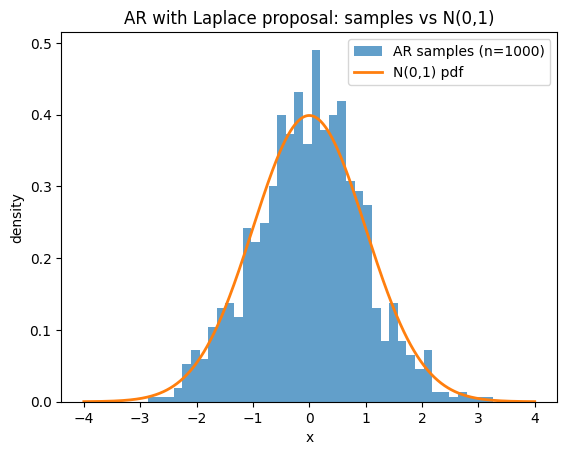

Uniform draws for 1000 samples: mean ≈ 2630.3, 95% CI ≈ [2625.5, 2635.2]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# target and proposal densities
def f_norm(x):
    return np.exp(-0.5*x*x) / np.sqrt(2*np.pi)

def g_laplace(x):
    return 0.5*np.exp(-np.abs(x))

# inversion sampler for Laplace(0,1)
def rlaplace_inv(n, rng):
    U = rng.random(n)
    return np.where(U <= 0.5, np.log(2*U), -np.log(2*(1-U)))

# AR sampler returning samples, acceptance rate, and total number of Uniform(0,1) draws used
def rnorm_via_AR(n, seed=None):
    rng = np.random.default_rng(seed)
    k = np.sqrt(2*np.e/np.pi)      # minimal envelope constant
    out, i, proposals = np.empty(n), 0, 0
    while i < n:
        y = rlaplace_inv(1, rng)[0]   # 1 uniform
        u = rng.random()              # +1 uniform
        if u <= f_norm(y) / (k * g_laplace(y)):
            out[i] = y
            i += 1
        proposals += 1
    acc_rate = n / proposals
    uniforms_used = 2 * proposals
    return out, acc_rate, uniforms_used

# --- one run for histogram ---
xs, acc, uniforms = rnorm_via_AR(1000, seed=2025)
print(f"Empirical acceptance ≈ {acc:.3f}, Uniform(0,1) draws used = {uniforms}")

# histogram vs true pdf
grid = np.linspace(-4, 4, 800)
plt.figure()
plt.hist(xs, bins=40, density=True, alpha=0.7, label="AR samples (n=1000)")
plt.plot(grid, f_norm(grid), lw=2, label="N(0,1) pdf")
plt.xlabel("x"); plt.ylabel("density")
plt.title("AR with Laplace proposal: samples vs N(0,1)")
plt.legend()
plt.show()

# --- repeated runs to estimate mean and 95% CI of uniform draws needed for 1000 samples ---
R = 200    # number of replications
totals = np.empty(R)
for r in range(R):
    _, _, ucnt = rnorm_via_AR(1000, seed=2025 + r)
    totals[r] = ucnt

mean_u = totals.mean()
se_u = totals.std(ddof=1) / np.sqrt(R)
ci_low, ci_high = mean_u - 1.96*se_u, mean_u + 1.96*se_u
print(f"Uniform draws for 1000 samples: mean ≈ {mean_u:.1f}, 95% CI ≈ [{ci_low:.1f}, {ci_high:.1f}]")

<hr>

**(d)** Now, suppose instead we choose the proposal distribution to be a Cauchy  distribution with pdf $g(x) = \frac{1}{\pi(1+x^2)}$. Describe and implement an inversion algorithm to get samples from this distribution, and plot the histogram of 1000 samples from this distribution.

<hr>

**Proposal:** standard Cauchy with pdf $g(x)=\dfrac{1}{\pi(1+x^2)}$.

**CDF and inverse.** The CDF is $G(x)=\dfrac{1}{\pi}\arctan(x)+\tfrac{1}{2}$.  
Given $U\sim\mathrm{U}(0,1)$, the inverse is
$
G^{-1}(U)=\tan\!\big(\pi(U-\tfrac{1}{2})\big).
$

**Algorithm (inversion).**
1) Draw $U\sim\mathrm{Unif}(0,1)$.  
2) Set $Y=\tan\!\big(\pi(U-\tfrac{1}{2})\big)$.  
Then $Y\sim\text{Cauchy}(0,1)$ with pdf $g(x)$.

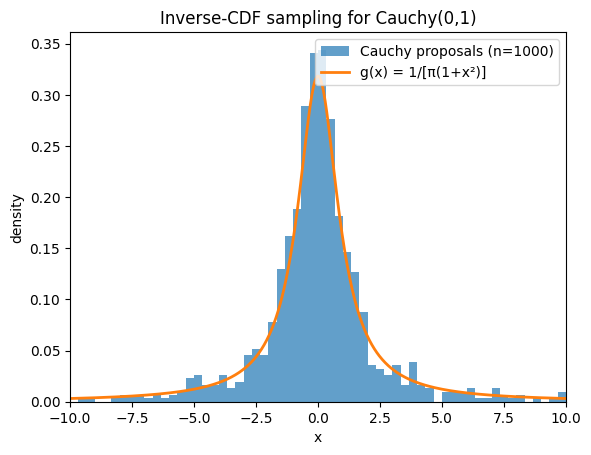

In [11]:

import numpy as np
import matplotlib.pyplot as plt

def rcauchy_inv(n, seed=None):
    rng = np.random.default_rng(seed)
    U = rng.random(n)
    return np.tan(np.pi*(U - 0.5))

# generate 1000 proposal samples and plot histogram
y = rcauchy_inv(1000, seed=2025)
plt.figure()
plt.hist(y, bins=60, density=True, alpha=0.7, range=(-10,10), label="Cauchy proposals (n=1000)")
grid = np.linspace(-10, 10, 1000)
plt.plot(grid, 1/(np.pi*(1+grid**2)), lw=2, label="g(x) = 1/[π(1+x²)]")
plt.xlim(-10,10)
plt.xlabel("x"); plt.ylabel("density")
plt.title("Inverse-CDF sampling for Cauchy(0,1)")
plt.legend()
plt.show()

<hr>

**(e)** Repeat parts $(b)$ and $(c)$ for this proposal distribution.

<hr>

### Ans.

**Target:** $f(x)=\dfrac{e^{-x^2/2}}{\sqrt{2\pi}}$.  
**Proposal:** $g(x)=\dfrac{1}{\pi(1+x^2)}$ (standard Cauchy).

#### Smallest $k$ with $k g(x)\ge f(x)$
$
k=\sup_x \frac{f(x)}{g(x)}
= \sqrt{\frac{\pi}{2}}\ \sup_x (1+x^2)\,e^{-x^2/2}.
$
Let $h(x)=\log\!\big((1+x^2)e^{-x^2/2}\big)=\log(1+x^2)-\tfrac{x^2}{2}$.
Then $h'(x)=\dfrac{2x}{1+x^2}-x=\dfrac{x(1-x^2)}{1+x^2}$, giving critical points $x=0,1$.

Evaluate: at $x=0$: $(1+0)e^{0}=1$; at $x=1$: $(2)e^{-1/2}=2e^{-1/2}$ (larger).

Hence
$
k=\sqrt{\tfrac{\pi}{2}}\cdot 2e^{-1/2}=\sqrt{2\pi}\,e^{-1/2}\approx 1.520.
$

Acceptance probability is $1/k\approx 0.658$, so the expected proposals per accepted is $k\approx 1.520$.


- **AR sampler with Cauchy proposal and summary for $n=1000$**

  - Each proposal uses **two** uniforms (one for inversion of Cauchy and one for acceptance).  
  - Expected uniforms per accepted sample: $2k\approx 3.041$.  
  - For $n=1000$, the theoretical mean uniforms $\approx 2k\times 1000\approx 3041$.

Empirical acceptance ≈ 0.660 (theory 1/k ≈ 0.658)
Uniform(0,1) draws used = 3030


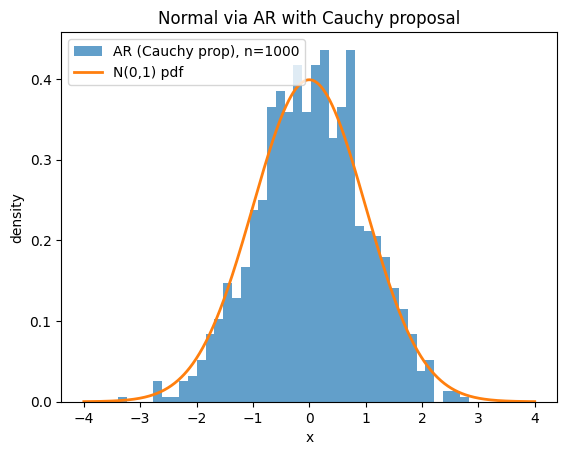

Uniform draws for 1000 samples: mean ≈ 3030.9, 95% CI ≈ [3023.3, 3038.6]


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# target and proposal densities
def f_norm(x):
    return np.exp(-0.5*x*x) / np.sqrt(2*np.pi)

def g_cauchy(x):
    return 1.0 / (np.pi*(1.0 + x*x))

# inversion sampler for Cauchy(0,1)
def rcauchy_inv(n, rng):
    U = rng.random(n)
    return np.tan(np.pi*(U - 0.5))

# AR sampler: N(0,1) using Cauchy proposal
def rnorm_AR_cauchy(n, seed=None):
    rng = np.random.default_rng(seed)
    k = np.sqrt(2*np.pi) * np.exp(-0.5)   # minimal envelope constant
    out, i, props = np.empty(n), 0, 0
    while i < n:
        y = rcauchy_inv(1, rng)[0]    # 1 uniform
        u = rng.random()              # +1 uniform
        if u <= f_norm(y) / (k * g_cauchy(y)):
            out[i] = y
            i += 1
        props += 1
    acc_rate = n / props
    uniforms_used = 2 * props
    return out, acc_rate, uniforms_used

# one run for histogram and summary
xs, acc, uniforms = rnorm_AR_cauchy(1000, seed=2025)
print(f"Empirical acceptance ≈ {acc:.3f} (theory 1/k ≈ {1/(np.sqrt(2*np.pi)*np.exp(-0.5)):.3f})")
print(f"Uniform(0,1) draws used = {uniforms}")

# plot histogram vs N(0,1) pdf
grid = np.linspace(-4, 4, 800)
plt.figure()
plt.hist(xs, bins=40, density=True, alpha=0.7, label="AR (Cauchy prop), n=1000")
plt.plot(grid, f_norm(grid), lw=2, label="N(0,1) pdf")
plt.xlabel("x"); plt.ylabel("density")
plt.legend()
plt.title("Normal via AR with Cauchy proposal")
plt.show()

# repeated runs to get mean and 95% CI for total uniforms
R = 200
totals = np.empty(R)
for r in range(R):
    _, _, ucnt = rnorm_AR_cauchy(1000, seed=2025+r)
    totals[r] = ucnt
mean_u = totals.mean()
se_u = totals.std(ddof=1)/np.sqrt(R)
ci = (mean_u - 1.96*se_u, mean_u + 1.96*se_u)
print(f"Uniform draws for 1000 samples: mean ≈ {mean_u:.1f}, 95% CI ≈ [{ci[0]:.1f}, {ci[1]:.1f}]")
